In [19]:
import os
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from datasets import load_dataset, load_from_disk, DatasetDict
from huggingface_hub import HfApi

In [20]:
pd.set_option("display.max_colwidth", None)

In [21]:
HUGGINGFACE_TOKEN = os.environ.get("HUGGINGFACE_TOKEN")

In [22]:
text_length_cutoff = 25000
perplexity_cutoff = 5000


def get_perplexity(meta):
    if isinstance(meta, str):
        meta = ast.literal_eval(meta)
    return int(meta["perplexity_score"])


def get_datasets():
    ola_datasets = [
        ds_info.id
        for ds_info in HfApi().list_datasets(
            use_auth_token=os.environ.get("HUGGINGFACE_TOKEN")
        )
        if (
            ds_info.id.startswith("ola13/small-")
            and not ds_info.id.startswith("ola13/small-roots")
        )
        or ds_info.id == "ola13/small-roots_en"
    ]
    datasets = {
        name.split("-")[-1]: pd.DataFrame(
            load_dataset(name, use_auth_token=os.environ.get("HUGGINGFACE_TOKEN"))[
                "train"
            ]
        )
        for name in ola_datasets
    }
    max_perplexity = 0
    min_length = 1000000
    max_length = 0
    for name in datasets.keys():
        dataset = datasets[name]
        dataset["perplexity_score"] = dataset.apply(
            lambda doc: get_perplexity(doc["meta"]), axis=1
        )
        dataset["text_length"] = dataset.apply(lambda doc: len(doc["text"]), axis=1)
        dataset["text_length_clipped"] = dataset.apply(
            lambda doc: doc["text_length"]
            if doc["text_length"] < text_length_cutoff
            else text_length_cutoff,
            axis=1,
        )
        dataset["perplexity_score_clipped"] = dataset.apply(
            lambda doc: doc["perplexity_score"]
            if doc["perplexity_score"] < perplexity_cutoff
            else perplexity_cutoff,
            axis=1,
        )
        for column in dataset.columns:
            if column not in [
                "text",
                "perplexity_score",
                "text_length",
                "text_length_clipped",
                "perplexity_score_clipped",
            ]:
                dataset = dataset.drop(column, axis=1)

        datasets[name] = dataset.sort_values("perplexity_score")
        datasets[name] = datasets[name].reset_index()
        max_perp = dataset["perplexity_score"].max()
        min_len = dataset["text_length"].min()
        max_len = dataset["text_length"].max()
        max_perplexity = max(max_perp, max_perplexity)
        min_length = min(min_len, min_length)
        max_length = max(max_len, max_length)
    return datasets, max_perplexity, min_length, max_length

In [23]:
datasets, max_perplexity, min_length, max_length = get_datasets()

Using custom data configuration ola13--small-the_pile-4ea951960b8e9f8a
Found cached dataset parquet (/mnt/disks/looking_glass_storage/hf_cache/ola13___parquet/ola13--small-the_pile-4ea951960b8e9f8a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]
Using custom data configuration ola13--small-c4-f67537b3f2cb384f
Found cached dataset parquet (/mnt/disks/looking_glass_storage/hf_cache/ola13___parquet/ola13--small-c4-f67537b3f2cb384f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:0

Extracting data files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 592.16it/s]


Dataset parquet downloaded and prepared to /mnt/disks/looking_glass_storage/hf_cache/ola13___parquet/ola13--small-roots_en-11cad66076508e44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 162.15it/s]


In [36]:
colors = ["blue", "green", "lime", "cyan"]

In [37]:
def plot_perplexity_histogram():
    plt.figure(figsize=(15, 5))
    legend_patches = []
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        x = dataset["perplexity_score_clipped"]
        n, bins, patches = plt.hist(x, 500, facecolor=colors[i], alpha=0.75)
        legend_patches.append(mpatches.Patch(color=colors[i], label=dataset_name))

    plt.xlim(0, perplexity_cutoff + 100)
    plt.ylim(0, 2500)

    plt.axvline(x=1500, linewidth=0.5, color="red")
    plt.xlabel("Perplexity")
    plt.ylabel("Count")
    plt.title("Histogram of Perplexities")
    plt.legend(handles=legend_patches)
    plt.savefig("figures/perplexity_histograms", dpi=1000)

    plt.show()

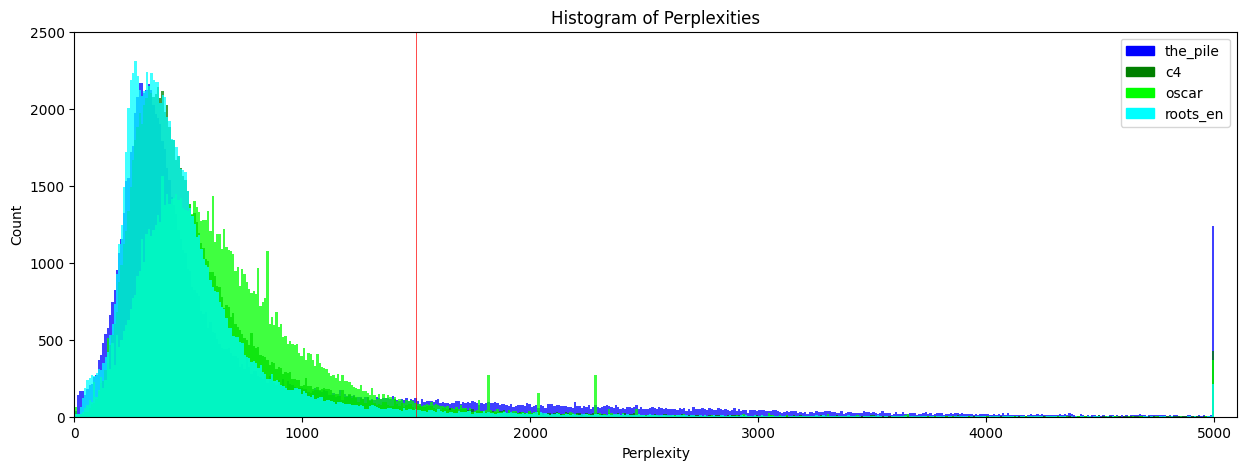

In [38]:
plot_perplexity_histogram()

In [39]:
def plot_text_length_histogram():
    plt.figure(figsize=(15, 5))
    legend_patches = []
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        x = dataset["text_length_clipped"]
        n, bins, patches = plt.hist(x, 500, facecolor=colors[i], alpha=0.75)
        legend_patches.append(mpatches.Patch(color=colors[i], label=dataset_name))

    plt.xlim(0, text_length_cutoff + 100)
    plt.ylim(0, 10500)

    plt.xlabel("Text Length")
    plt.ylabel("Count")
    plt.title("Histogram of Text Lengths")
    plt.legend(handles=legend_patches)
    plt.savefig("figures/text_length_histograms", dpi=1000)

    plt.show()

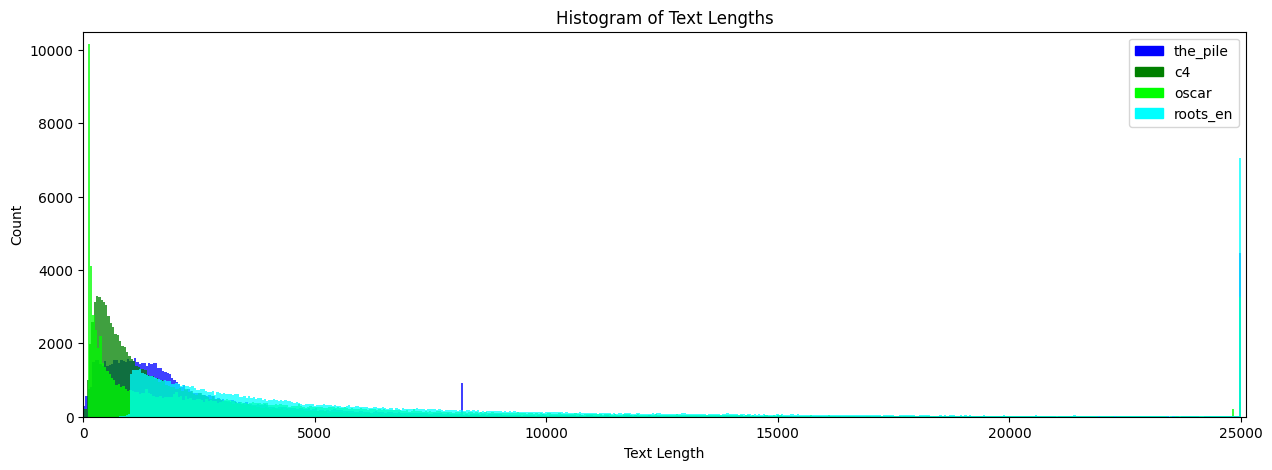

In [40]:
plot_text_length_histogram()

In [41]:
def plot_base(dataset_name, cutoff):
    dataset = datasets[dataset_name]
    plt.figure(figsize=(15, 5))

    idx_out = dataset[dataset["perplexity_score"] >= cutoff].index

    x = dataset["text_length"]
    y = dataset["perplexity_score"]

    x_out = dataset["text_length"].iloc[idx_out]
    y_out = dataset["perplexity_score"].iloc[idx_out]

    plt.xlim(0, perplexity_cutoff + 100)
    plt.ylim(0, 5000)

    plt.scatter(x, y, marker=".", s=1, color="g", linewidths=0)
    plt.scatter(x_out, y_out, marker=".", s=1, color="r", linewidths=0)

    plt.axhline(y=1500, color="b", linestyle="-", linewidth=0.5)
    included = len(dataset[dataset["perplexity_score"] < 1500])
    ratio = (100 * included) / len(dataset)
    plt.text(
        perplexity_cutoff - 1500,
        1550,
        "Current threshold, included ratio: " + str(ratio),
        color="b",
    )

    plt.xlabel("Text length")
    plt.ylabel("Perplexity")
    plt.title(dataset_name)
    return plt

In [42]:
def plot_full(dataset_name, cutoff):
    plt = plot_base(dataset_name, cutoff)
    dataset = datasets[dataset_name]
    idx_out = dataset[dataset["perplexity_score"] >= cutoff].index

    x_out = dataset["text_length"].iloc[idx_out]
    y_out = dataset["perplexity_score"].iloc[idx_out]

    plt.scatter(x_out, y_out, marker=".", s=1, color="r", linewidths=0)

    plt.axhline(y=cutoff, color="k", linestyle="-", linewidth=0.5)

    ratio = 100 * (len(dataset) - len(x_out)) / len(dataset)
    plt.text(perplexity_cutoff - 1500, 3500, "Green ratio: " + str(ratio), fontsize=15)
    plt.savefig("figures/" + dataset_name + "_split", dpi=1000)
    plt.show()

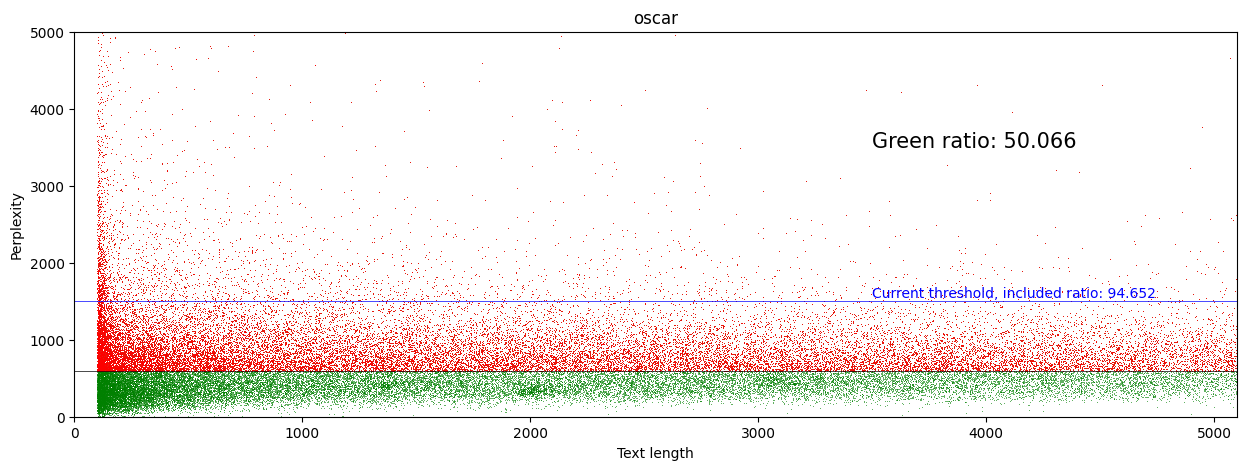

In [43]:
cutoff = 590
plt_base = plot_full("oscar", cutoff)

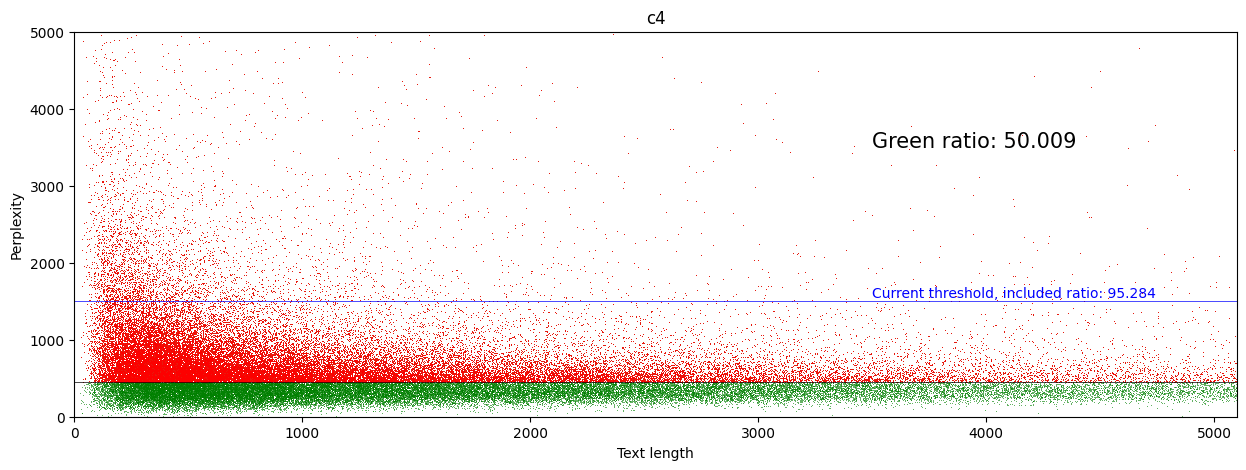

In [44]:
cutoff = 451
plt_base = plot_full("c4", cutoff)

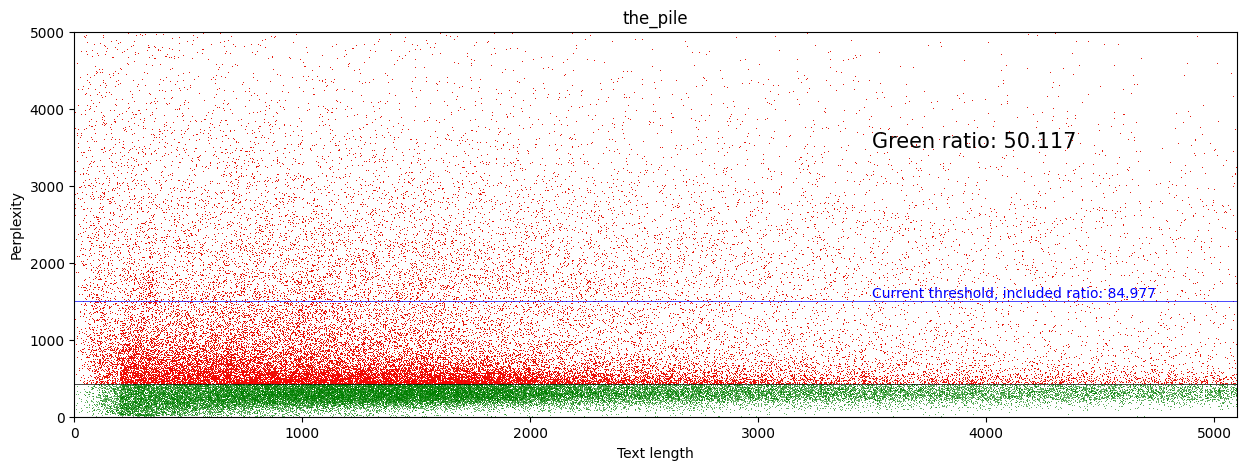

In [45]:
cutoff = 431
plt_base = plot_full("the_pile", cutoff)

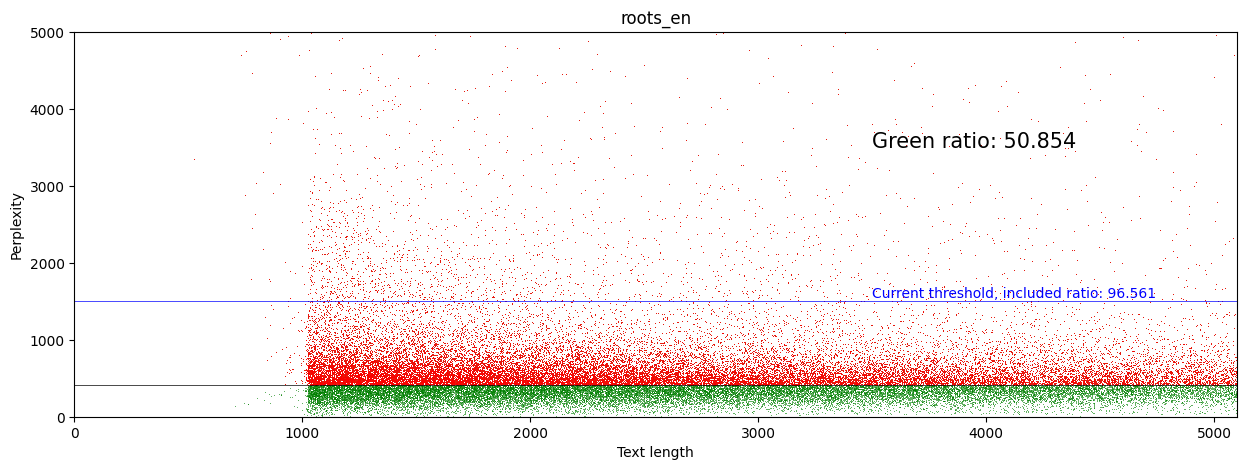

In [54]:
cutoff = 415
plt_base = plot_full("roots_en", cutoff)

In [55]:
def plot_simple(dataset_name):
    dataset = datasets[dataset_name]
    plt.figure(figsize=(15, 5))

    x = dataset["text_length"]
    y = dataset["perplexity_score"]

    plt.xlim(0, 10000)
    plt.ylim(0, 5000)

    plt.scatter(x, y, marker=".", s=1, color="g", linewidths=0)

    plt.xlabel("Perplexity")
    plt.ylabel("Text length")
    plt.title(dataset_name)
    plt.savefig("figures/" + dataset_name, dpi=1000)
    return plt

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

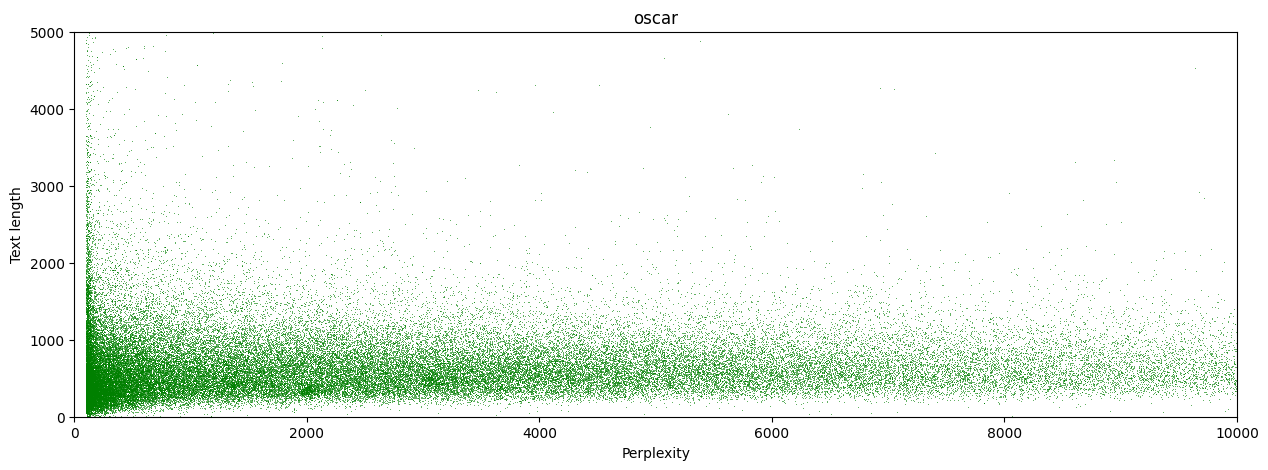

In [56]:
plot_simple("oscar")